In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
def trend(time, slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)

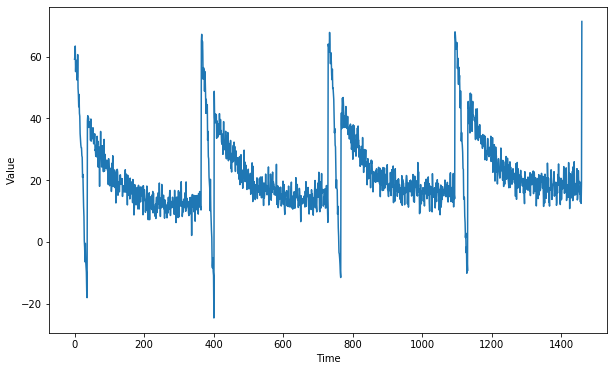

In [3]:
def generate_time_series():
    time = np.arange(4*365+1, dtype="float32")
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    amplitude = 50
    series+=seasonality(time, period=365, amplitude=amplitude)

    noise_level=3
    series+=noise(time, noise_level, seed=51)
    return time, series

@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(series_train)

In [10]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x:x*100)
    ])
    return model

In [11]:
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


In [12]:
def adjust_learning_rate():
    model = create_uncompiled_model()
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-6*10**(epoch/20))

    optimizer = tf.keras.optimizers.SGD()

    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    return history

In [13]:
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 10s 27ms/step - loss: 22.3044 - mae: 22.8040 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 1s 24ms/step - loss: 13.6065 - mae: 14.1035 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 1s 20ms/step - loss: 6.1124 - mae: 6.5939 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 1s 23ms/step - loss: 4.4599 - mae: 4.9200 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 1s 20ms/step - loss: 4.4258 - mae: 4.8909 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 1s 23ms/step - loss: 4.4143 - mae: 4.8802 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 1s 26ms/step - loss: 4.3994 - mae: 4.8646 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 1s 25ms/step - loss: 4.3914 - mae: 4.8582 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 1s 23ms/step - loss: 4.3747 - mae: 4.8395 - lr

[1e-06, 1, 0, 30]

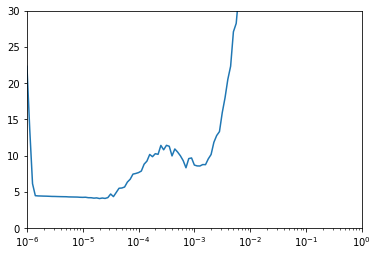

In [14]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

In [18]:
def create_model():
    tf.random.set_seed(51)
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate= 1e-6, momentum=0.9), metrics =["mae"])
    return model

In [19]:
model = create_model()
history= model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 10s 21ms/step - loss: 33.1681 - mae: 33.6663
Epoch 2/50
34/34 [==============================] - 1s 19ms/step - loss: 6.5220 - mae: 7.0027
Epoch 3/50
34/34 [==============================] - 1s 18ms/step - loss: 5.3422 - mae: 5.8117
Epoch 4/50
34/34 [==============================] - 1s 19ms/step - loss: 4.9423 - mae: 5.4058
Epoch 5/50
34/34 [==============================] - 1s 19ms/step - loss: 4.7569 - mae: 5.2190
Epoch 6/50
34/34 [==============================] - 1s 19ms/step - loss: 4.6399 - mae: 5.1034
Epoch 7/50
34/34 [==============================] - 1s 19ms/step - loss: 4.5747 - mae: 5.0398
Epoch 8/50
34/34 [==============================] - 1s 19ms/step - loss: 4.5049 - mae: 4.9687
Epoch 9/50
34/34 [==============================] - 1s 17ms/step - loss: 4.4582 - mae: 4.9195
Epoch 10/50
34/34 [==============================] - 1s 18ms/step - loss: 4.3959 - mae: 4.8583
Epoch 11/50
34/34 [==============================] - 1s 

In [20]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

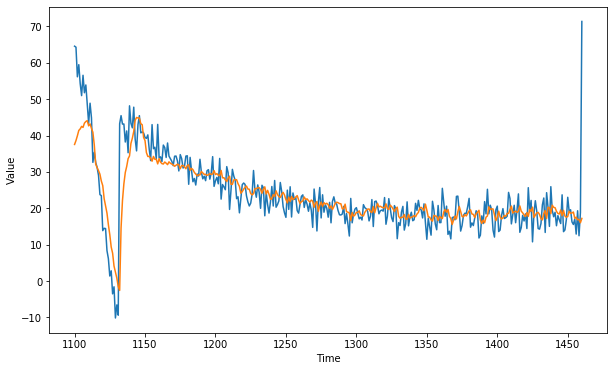

In [21]:
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [22]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 41.49, mae: 3.86 for forecast


In [23]:
model.save('my_model2.h5')